# Neural coding in barrel cortex during whisker-guided locomotion

This notebook loads and plots and tables derived from the calcium imaging data found in Sofroniew\*, Vlasov\*, et al. (submitted 2015) and will reproduce figure 3 panels c-g.

## Setup

#### Evnironment

In [1]:
import os
import numpy as np
import pandas as pd
import json

#### Plotting

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')
from helper.plots import *

####Widgets

In [322]:
from IPython.html import widgets
from IPython.display import display
from IPython.html.widgets import interactive
from IPython.html.widgets import interact

In [328]:
def printOpt(source):
    source

In [329]:
def listSources(animal):
    sourcesList = table.index.tolist()
    sources.options = [str(x[1]) for x in sourcesList if x[0] == animal]

In [330]:
sources = widgets.Select(options = ['ss', 'll'])
wS = interactive(printOpt, source=sources)

In [331]:
animals = widgets.Dropdown(options = info.index.tolist())
wA = interactive(listSources, animal=animals)

In [332]:
display(wA,wS)

#### Helper functions for loading and processing data

This helper function is using during loading to align tables to a primary key

In [14]:
def align(table, primary, index):
    table['sourceId'] = primary['sourceId']
    table.set_index(index,inplace = True)
    table.columns = table.columns.astype('float')
    return table

This helper function loads mutliple tables from a session into a dictionary where the keys are table names

In [15]:
def load(session):
    # load the info
    with open(os.path.join(path,'data',session,'info.json')) as infile:
        info = json.load(infile)
        
    d = {}

    # load the units (which have our primary keys)
    d['units'] = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','units.csv'))
    d['units']['sourceId'] = d['units'].index
    
    # load all the tables    
    d['tuning'] = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','tuning.csv'))   
    d['tuning'] = align(d['tuning'], d['units'], ['sourceId', 'label'])
    d['tuningNum'] = d['tuning'].xs('numTrials', level='label')
    err = d['tuning'].xs('stdRate', level='label').divide(d['tuningNum'].apply(np.sqrt))
    d['tuning'] = d['tuning'].xs('meanRate', level='label')
    d['tuningErr'] = err
    d['tuningSummary'] = summarizeTuning(d['tuning'])
  
    # load all the tables    
    d['tuningSpeed'] = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','tuning-speed.csv'))   
    d['tuningSpeed'] = align(d['tuningSpeed'], d['units'], ['sourceId', 'label'])
    d['tuningSpeedNum'] = d['tuningSpeed'].xs('numTrials', level='label')
    err = d['tuningSpeed'].xs('stdRate', level='label').divide(d['tuningSpeedNum'].apply(np.sqrt))
    d['tuningSpeed'] = d['tuningSpeed'].xs('meanRate', level='label')
    d['tuningSpeedErr'] = err
    d['tuningSpeedSummary'] = summarizeTuning(d['tuningSpeed'])
  
    d['units'] = d['units'].drop(['sourceId'], axis=1)
    
    # add tables
    d = pd.concat([d[x] for x in d.keys()], axis = 1, keys = d.keys())
    
    info['contributors'] = ', '.join(info['contributors'])
    info['dimensions'] = str(info['dimensions'])
    info['session'] = session
    info = pd.DataFrame(info, index = [str(info['id'])])
    
    #d['info'] = info
    return d, info

Append position tuning information to units data frame

In [16]:
def summarizeTuning(df):
    x = df.columns.values
    xs, ys = smoothfit(x, df.values[0],smooth=smooth)
    smoothed = [smoothfit(x, y, smooth=smooth)[1] for y in df.values]

    summary = pd.DataFrame(index=df.index)
    summary['Baseline'] = [y[-1] for y in smoothed]
    summary['Max'] = [max(y) for y in smoothed]
    summary['ArgMax'] = [xs[np.argmax(y)] for y in smoothed]
    summary['Min'] = [min(y) for y in smoothed]
    summary['Mean'] = [np.mean(y) for y in smoothed]

    summary['Activation'] = summary.Max - summary.Baseline
    summary['Supression'] = summary.Baseline - summary.Min
    summary['Range'] = summary.Max - summary.Min
    summary['Modulation'] = (summary.Activation - summary.Supression)/(summary.Activation + summary.Supression)
    summary['TotalModulation'] = (summary.Max - summary.Min)/(summary.Max + summary.Min)
    return summary

Define smooth parameter

In [17]:
smooth = 1

## Load JSON + CSV as DataFrames

For each animal there is an info.json file with metadata descibring the experiment, and there are .csv files with tabular data where each row contains data recorded from a single neuron

#### Specify location of the data

In [18]:
path = os.path.expanduser('~/Dropbox/paper.tuning')

#### Load the tables from each session

In [19]:
sessions = range(13,19)
data = [load('%02g' % s) for s in sessions]
table =  pd.concat([x[0] for x in data], keys=[str(x[1].index[0]) for x in data], names=['anmId'])
info =  pd.concat([x[1] for x in data])

/Users/sofroniewn/anaconda/lib/python2.7/site-packages/scipy/interpolate/fitpack2.py:220: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


## Summarize units

In [20]:
units = table.units.reset_index()
unitCount = units.groupby(['anmId']).count()['sourceId'].values
units.set_index(['anmId', 'sourceId'], inplace=True)
unitSummary = pd.Series({'total':len(units), 'mean':np.mean(unitCount), 'std':np.std(unitCount), 'numAnm':len(unitCount)})
unitSummary

mean       336.500000
numAnm       6.000000
std         69.875484
total     2019.000000
dtype: float64

#### Plot fractions of active and tuned neurons

In [21]:
tuned = (units.pVal<0.05) & (table.tuningSummary.Range > .3)
active = units.activity > 1.0
summaryActivity = pd.DataFrame([sum((~active) & (~tuned)), sum(tuned), sum(active & (~tuned))], index=['inactive','tuned','untuned'], columns=['number'])
summaryActivity['percent'] = 100*summaryActivity.number/summaryActivity.number.sum()
summaryActivity

,number,percent
inactive,1121,55.522536
tuned,564,27.934621
untuned,334,16.542843


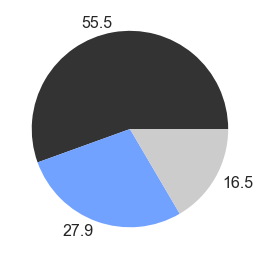

In [22]:
col = colormap()(0)[:3]
plt.axes(aspect=1);
plt.pie(summaryActivity.percent, labels=['%.1f' % summaryActivity.percent.iloc[0],'%.1f' % summaryActivity.percent.iloc[1],'%.1f' % summaryActivity.percent.iloc[2]], colors=[[.2, .2, .2],col,[.8, .8, .8]], wedgeprops={'linewidth':0});

# Plot tuning curves

The paper includes the following tuning curves
* 'Anm_0216166', 150
* 'Anm_0216166', 160
* 'Anm_0216166', 159

In [333]:
display(wA,wS)

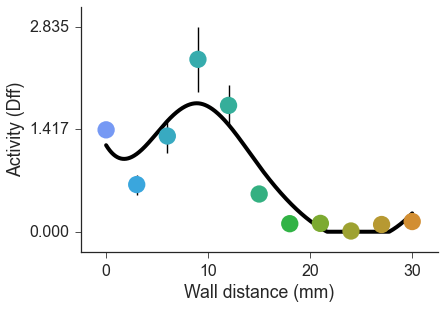

In [339]:
a = wA.kwargs['animal']
u = int(wS.kwargs['source'])
x = table.tuning.columns.values
y = table.tuning.loc[a,u].values
err = table.tuningErr.loc[a,u].values
tuning(x, y, err, smooth=smooth, ylabel='Activity (Dff)');

## Plot summary tuning curves

#### Keep significantly tuned units

In [13]:
table = table[tuned.values]
units = units[tuned.values]

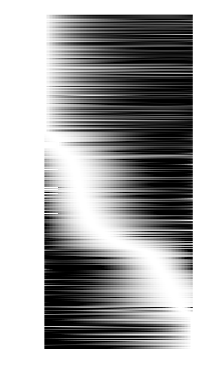

In [14]:
curves = table.sort([('tuningSummary','ArgMax')])
xy = [(curves.tuning.columns.values, y) for y in curves.tuning.values]
fits = smootharray(xy, smooth=smooth, res=100)
heatmap(fits, aspect=.4)

## Plot summary tuning

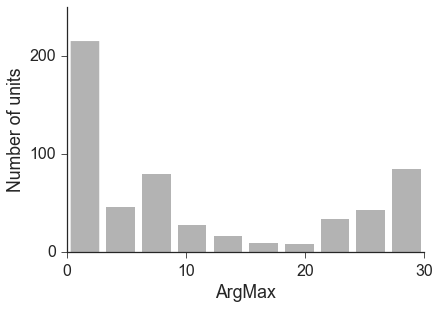

In [15]:
hist(table.tuningSummary.ArgMax, xlabel='ArgMax', ylabel='Number of units')
plt.xticks(range(0,40,10));
plt.yticks(range(0,300,100));

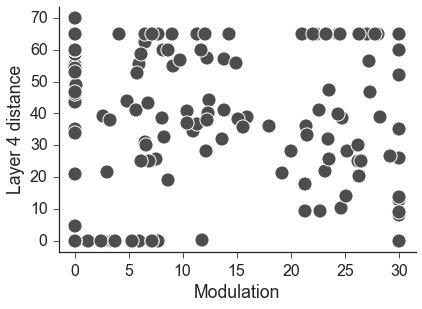

In [25]:
x = table.tuningSummary.ArgMax[units['pVal-speed']<0.05]
y = table.tuningSpeedSummary.ArgMax[units['pVal-speed']<0.05]
scatter(x, y, xlabel='Modulation', ylabel='Layer 4 distance')

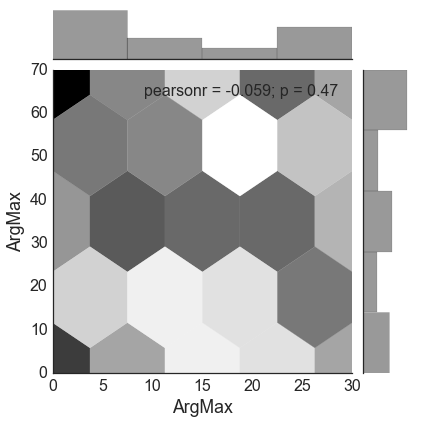

In [26]:
with sns.axes_style("white"):
    sns.jointplot(x=x, y=y, kind="hex", color="k");

0.44


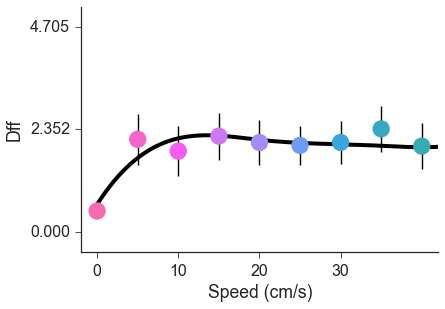

In [37]:
a = 'Anm_0216166'
u = 159
x = table.tuningSpeed.columns.values
y = table.tuningSpeed.loc[a,u].values
err = table.tuningSpeedErr.loc[a,u].values
x = x[~np.isnan(y)]
err = err[~np.isnan(y)]
y = y[~np.isnan(y)]
pal = sns.color_palette("husl", n_colors=len(x) + 6)
pal = pal[6:6+len(x)][::-1]
rng = tuning(x, y, err, smooth=smooth, pal=pal, ylabel='Dff', label = 'Speed (cm/s)');
print '%.2f' % table.tuningSpeedSummary.Modulation.loc[a,u]
plt.xlim([-2, 42]);
#plt.yticks([0, 15, 30]);